<a href="https://colab.research.google.com/github/ravi-murugesan/ftds6/blob/master/Energy_train_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import operator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import math

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd 
train = pd.read_csv('/content/drive/My Drive/Energy/ashrae-energy-prediction/train.csv')
train.head(3)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0


In [5]:
import pandas as pd 
weather = pd.read_csv('/content/drive/My Drive/Energy/ashrae-energy-prediction/weather_train.csv')
weather.head(3)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0


In [9]:
train.isnull().any()

building_id      False
meter            False
timestamp        False
meter_reading    False
dtype: bool

In [25]:
weather.shape,weather.columns

((139773, 9),
 Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
        'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
        'wind_direction', 'wind_speed'],
       dtype='object'))

In [23]:
weather.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [0]:
weather1 = weather[['site_id', 'air_temperature',
        'dew_temperature', 'wind_direction', 'wind_speed']]

In [27]:
weather1.head(5)

,site_id,air_temperature,dew_temperature,wind_direction,wind_speed
0,0,25.0,20.0,0.0,0.0
1,0,24.4,21.1,70.0,1.5
2,0,22.8,21.1,0.0,0.0
3,0,21.1,20.6,0.0,0.0
4,0,20.0,20.0,250.0,2.6


In [44]:
weather1['sin_dire'] = np.sin(2*np.pi*(weather1.wind_direction/360))
weather1['cos_dire'] = np.cos(2*np.pi*(weather1.wind_direction/360))

weather1.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,site_id,air_temperature,dew_temperature,wind_direction,wind_speed,sin_dire,cos_dire
0,0,25.0,20.0,0.0,0.0,0.000000,1.00000
1,0,24.4,21.1,70.0,1.5,0.939693,0.34202


In [45]:
weather1['sin_s'] = weather1['wind_speed']*weather1['sin_dire']
weather1['cos_s'] = weather1['wind_speed']*weather1['cos_dire']

weather1.head(3)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,site_id,air_temperature,dew_temperature,wind_direction,wind_speed,sin_dire,cos_dire,sin_s,cos_s
0,0,25.0,20.0,0.0,0.0,0.000000,1.00000,0.000000,0.00000
1,0,24.4,21.1,70.0,1.5,0.939693,0.34202,1.409539,0.51303
2,0,22.8,21.1,0.0,0.0,0.000000,1.00000,0.000000,0.00000


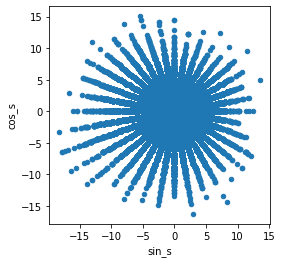

In [46]:
weather1.plot.scatter('sin_s','cos_s').set_aspect('equal')

In [48]:
weather2 = weather1.drop(['wind_direction','wind_speed','sin_dire','cos_dire'],axis=1)
weather2.head(5)

,site_id,air_temperature,dew_temperature,sin_s,cos_s
0,0,25.0,20.0,0.000000,0.000000
1,0,24.4,21.1,1.409539,0.513030
2,0,22.8,21.1,0.000000,0.000000
3,0,21.1,20.6,0.000000,0.000000
4,0,20.0,20.0,-2.443201,-0.889252


In [51]:
weather2.shape,weather.shape

((139773, 5), (139773, 9))

In [0]:
write1 = weather2.to_csv('/content/drive/My Drive/Energy/ashrae-energy-prediction/weather_train_clean.csv')

In [1]:
import pandas as pd 
weather2 = pd.read_csv('/content/drive/My Drive/Energy/ashrae-energy-prediction/weather_train_clean.csv',index_col=0)
weather2.head(3)

,site_id,air_temperature,dew_temperature,sin_s,cos_s
0,0,25.0,20.0,0.000000,0.00000
1,0,24.4,21.1,1.409539,0.51303
2,0,22.8,21.1,0.000000,0.00000


In [2]:
weather2.shape

(139773, 5)

In [64]:
train.head(3)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0


In [5]:
import pandas as pd 
build = pd.read_csv('/content/drive/My Drive/Energy/ashrae-energy-prediction/build_clean.csv',index_col=0)
build.head(3)

,site_id,building_id,primary_use,square_feet
0,0,0,1,0.008494
1,0,1,1,0.003109
2,0,2,1,0.006144


In [6]:
df_site = pd.merge(train,build, on='building_id',how='outer')
df_site.head(5)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet
0,0,0,2016-01-01 00:00:00,0.0,0,1,0.008494
1,0,0,2016-01-01 01:00:00,0.0,0,1,0.008494
2,0,0,2016-01-01 02:00:00,0.0,0,1,0.008494
3,0,0,2016-01-01 03:00:00,0.0,0,1,0.008494
4,0,0,2016-01-01 04:00:00,0.0,0,1,0.008494


In [0]:
write1 = df_site.to_csv('/content/drive/My Drive/Energy/ashrae-energy-prediction/cleaned_build&trainonly.csv')

In [4]:
import pandas as pd 
df_site = pd.read_csv('/content/drive/My Drive/Energy/ashrae-energy-prediction/cleaned_build&trainonly.csv',index_col=0)
df_site.head(3)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet
0,0,0,2016-01-01 00:00:00,0.0,0,1,0.008494
1,0,0,2016-01-01 01:00:00,0.0,0,1,0.008494
2,0,0,2016-01-01 02:00:00,0.0,0,1,0.008494


In [5]:
df_site.shape,weather2.shape


((20216100, 7), (139773, 5))

In [1]:
import pandas as pd 
df_site = pd.read_csv('/content/drive/My Drive/Energy/ashrae-energy-prediction/cleaned_build&trainonly.csv',index_col=0)
df_site.head(3)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet
0,0,0,2016-01-01 00:00:00,0.0,0,1,0.008494
1,0,0,2016-01-01 01:00:00,0.0,0,1,0.008494
2,0,0,2016-01-01 02:00:00,0.0,0,1,0.008494


In [2]:
import pandas as pd 
weather2 = pd.read_csv('/content/drive/My Drive/Energy/ashrae-energy-prediction/weather_train_clean.csv',index_col=0)
weather2.head(3)

,site_id,air_temperature,dew_temperature,sin_s,cos_s
0,0,25.0,20.0,0.000000,0.00000
1,0,24.4,21.1,1.409539,0.51303
2,0,22.8,21.1,0.000000,0.00000


In [5]:
df_site1 = df_site.iloc[:5000000]
df_site2 = df_site.iloc[5000000:10000000]
df_site3 = df_site.iloc[10000000:15000000]
df_site4 = df_site.iloc[15000000:20000000]
df_site5 = df_site.iloc[20000000:]
df_site1.shape,df_site2.shape,df_site3.shape,df_site4.shape,df_site5.shape

((5000000, 7), (5000000, 7), (5000000, 7), (5000000, 7), (216100, 7))

In [0]:
df1= pd.merge(df_site1,weather2, on='site_id',how='outer')
df1.head(5)